In [51]:
import pandas as pd

import boto3
from boto3.dynamodb.conditions import Key, Attr

dynamodb = boto3.resource('dynamodb')
indexTable = dynamodb.Table('nr-wsip-posts_index')

In [52]:
response = indexTable.query(
    KeyConditionExpression=Key('day').eq('2017-05-20')
)
items_5_20 = response['Items']

response = indexTable.query(
    KeyConditionExpression=Key('day').eq('2017-05-21')
)
items_5_21 = response['Items']

items = items_5_20 + items_5_21

In [54]:
def parse_decimals(item):
    dec_fields = ['created_utc', 'last_updated', 'score']
    for f in dec_fields:
        item[f] = int(item[f])
    return item
    
items = [parse_decimals(i) for i in items]
items = pd.DataFrame(items)

date_fields = ['created_utc', 'last_updated']

for d in date_fields:
    items[d] = items[d].map(lambda x: pd.Timestamp(x, unit='s'))
    
items = items.assign(alive_time=(items['last_updated'] - items['created_utc']))

dataTable = dynamodb.Table('nr-wsip-posts_data')

def get_data_item(id):
    try:
        response = dataTable.get_item(
            Key={
                'id': id
            }
        )
        data_item = response['Item']
        return data_item
    except:
#         print("bad response for id {0}".format(id))
        return {}

data = [get_data_item(id) for _, id in items['id'].iteritems()]
data = pd.DataFrame(data).set_index('id')

items = items.join(data, on='id')

In [103]:
sh_items = items[items['subreddit'] == 'Showerthoughts']
min_alive_time = 8

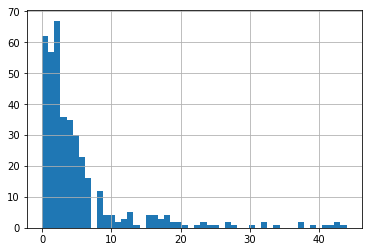

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
scores = sh_items[sh_items['alive_time'] > pd.Timedelta(hours=min_alive_time)]['score']
scores[scores < 51].hist(bins=50)


In [59]:
min_alive_time = 4

counts = items[items['alive_time'] >= pd.Timedelta(hours=min_alive_time)].groupby("subreddit").count()['score'].sort_values(ascending=False)
med_scores = items.groupby("subreddit").median()['score'].sort_index(ascending=False)

In [116]:
results = {sub: get_diffs_for_sub(sub, 4, 10, 5) for sub in counts[counts > 30].index}

for k, v in results.items():
    print("================")
    print("===== {0} - best".format(k))
    print(v['best'])
    print("===== {0} - worst".format(k))
    print(v['worst'])
    print("================")

===== AskReddit - best
your       0.278249
reddit     0.120056
most       0.114407
what's     0.111582
thing      0.091808
people     0.083333
ever       0.072034
serious    0.063559
one        0.057910
like       0.052260
dtype: float64
===== AskReddit - worst
stores      0.001412
eyedrops    0.001412
problem     0.001412
clothing    0.001412
shoes       0.001412
industry    0.001412
pt          0.001412
cruiser     0.001412
eternity    0.001412
cannot      0.001412
dtype: float64
===== The_Donald - best
trump        0.153443
we           0.124002
seth         0.101547
they         0.082585
rich         0.082086
about        0.077096
his          0.072106
donald       0.071607
when         0.070609
president    0.070609
dtype: float64
===== The_Donald - worst
shortened    0.00025
retreated    0.00025
mud          0.00025
beard        0.00025
backyard     0.00025
chipped      0.00025
lousy        0.00025
flies        0.00025
scraggly     0.00025
candy        0.00025
dtype: float64
====

In [115]:
from collections import Counter, defaultdict
import re

def get_diffs_for_sub(sub, min_alive_hours, non_good_max, good_min):
    def classif_sub_posts(score):
        if score >= good_min:
            return True
        elif score <= non_good_max:
            return False
        else:
            return 
    sub_posts = items[items['subreddit'] == sub]
    sub_posts = sub_posts[sub_posts['alive_time'] >= pd.Timedelta(hours=min_alive_hours)]
    sub_posts = sub_posts.assign(good=sub_posts['score'].apply(classif_sub_posts))
    sub_posts = sub_posts.dropna(subset=['good'])
    
    def to_message(row):
        is_good = row['good']
        words = "{0} {1}".format(row['title'], row['selftext'])
        return (words, is_good)
    
    messages = [to_message(post) for _, post in sub_posts.iterrows()]
    
    word_probs = messages_to_word_probabilities(messages)
    
    words_good = [(word, p_good) for word, p_good, p_bad in word_probs]
    words_bad = [(word, p_bad) for word, p_good, p_bad in word_probs]
    
    def to_series(word_tups):
        words, scores = zip(*word_tups)
        return pd.Series(scores, index=words)
    
#     best = to_series(words_good).sort_values(ascending=False).head(100)
#     worst = to_series(words_bad).sort_values(ascending=False).head(100)
    
#     best_index_unique = np.setdiff1d(best.index, worst.index)
#     best = best[best_index_unique].sort_values(ascending=False).head(10)
    
#     worst_index_unique = np.setdiff1d(worst.index, best.index)
#     worst = worst[worst_index_unique].sort_values(ascending=False).head(10)
#     diffs = word_diffs(messages)

    diffs = to_series(words_good).sort_values(ascending=False)
    best = diffs.head(10)
    worst = diffs.tail(10).sort_values()
    return {"best": best, "worst": worst }


def tokenize(message):
    stops = ['or', 'who', 'would', 'had', 'any' 'at', 'got', 'l', 'my', 'me', 'does','get', 'were', 'what', 'at', 'too', 'as', 's', 'an', 'than', 'do', 'so', 'no', 'it', 'how', 'be', 'has',  'a','can', 'will', 'have', 'if', 'why', 'but','he', 'the', 'and', 'on', 'all', 'is', 'emptystring', 'are', 'said', 'in', 'of', 'just', 'that', 'i', 'with', 'was', 'r', 't', 'to', 'for', 'by', 'you', 'there', 'not', 'to', 'from', 'this', '0' , '1', '2', '3', '4', '5', '6', '7', '8', '9']
    message = message.lower()                       # convert to lowercase
    all_words = re.findall("[a-z0-9']+", message)   # extract the words
    filt_words = list(filter(lambda x: x not in stops, all_words))
    
    return set(filt_words)                          # remove duplicates


def count_words(messages):
    """training set consists of pairs (message, is_spam)"""
    counts = defaultdict(lambda: [0, 0])
    for message, is_good in messages:
        for word in tokenize(message):
            counts[word][0 if is_good else 1] += 1
    return counts

def word_probabilities(counts, total_goodposts, total_non_goodposts, k=0.5):
    """turn the word_counts into a list of triplets
    w, p(w | good) and p(w | ~good)"""
    return [(w,
             (good + k) / (total_goodposts + 2 * k),
             (non_good + k) / (total_non_goodposts + 2 * k))
             for w, (good, non_good) in counts.items()]

def messages_to_word_probabilities(messages):
    num_goodposts = len([is_good
                     for message, is_good in messages
                     if is_good])
    num_non_goodposts = len(messages) - num_goodposts

    # run training data through our "pipeline"
    k = 0.5
    word_counts = count_words(messages)
    word_probs = word_probabilities(word_counts,
                                         num_goodposts,
                                         num_non_goodposts,
                                         k)
    
    return word_probs
#     words_and_diffs = [(word, (p_good - p_bad)) for word, p_good, p_bad in word_probs]
    
    # try just the p_good
#     words_and_diffs = [(word, p_good) for word, p_good, p_bad in word_probs]

#     if len(words_and_diffs) == 0:
#         return pd.Series()
#     words, diffs = zip(*words_and_diffs)
#     diffs = pd.Series(diffs, index=words).sort_values(ascending=False)
#     return diffs.sort_values(ascending=False)